In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
from seqeval.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from seqeval.scheme import BILOU
import os
os.environ["ACCELERATE_DISABLE_RICH"] = "1"
import torch
import torch.nn as nn
from datasets import load_dataset



/home/rodrigo.michel@senac.br/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_json("base_ner_completa_retreino_sintetica.jsonl", lines=True)
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['text', 'spans'],
    num_rows: 15270
})

## DISTILBERT

In [ ]:
# === 2. Definir modelo e tokenizer
model_name = "distilbert/distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# === 3. Criar label2id e id2label com base nos spans
def get_label_set(examples):
    return sorted(set(span["label"] for spans in examples["spans"] for span in spans))

entity_labels = get_label_set(df)

prefixes = ["B-", "I-", "L-", "U-"]
label_list = ["O"] + [f"{p}{ent}" for ent in entity_labels for p in prefixes] + ["PAD"]

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# === 4. Função de tokenização com alinhamento BILOU
def bilou_encode(example):
    tokens = tokenizer(example["text"], truncation=True, return_offsets_mapping=True)
    word_labels = ["O"] * len(tokens["input_ids"])
    offset_mapping = tokens["offset_mapping"]

    for span in example["spans"]:
        start, end, label = span["start"], span["end"], span["label"]
        matched = []

        for i, (s, e) in enumerate(offset_mapping):
            if s >= end or e <= start:
                continue
            matched.append(i)

        if len(matched) == 1:
            word_labels[matched[0]] = "U-" + label
        elif len(matched) >= 2:
            word_labels[matched[0]] = "B-" + label
            for i in matched[1:-1]:
                word_labels[i] = "I-" + label
            word_labels[matched[-1]] = "L-" + label

    tokens["labels"] = [label2id.get(tag, label2id["O"]) for tag in word_labels]
    return tokens

# === 5. Tokenizar e dividir o dataset
tokenized_dataset = dataset.map(bilou_encode, batched=False)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# === 6. Métricas com seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for pred, label in zip(predictions, labels):
        temp_preds, temp_labels = [], []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                temp_preds.append(id2label[p_i])
                temp_labels.append(id2label[l_i])
        true_predictions.append(temp_preds)
        true_labels.append(temp_labels)

    return {
        "precision": precision_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "recall": recall_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "f1": f1_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
    }

# === 7. Preparar modelo, argumentos e Trainer
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

use_cuda = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="./output_bertimbau",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    run_name="distilbert_bilou_ep8",
    save_total_limit=2
)




data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# === 8. Treinar modelo
trainer.train()

# === 9. Avaliação final
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions, axis=2)

true_preds = []
true_labels = []

for pred_seq, label_seq in zip(preds, labels):
    temp_preds, temp_labels = [], []
    for p_i, l_i in zip(pred_seq, label_seq):
        if l_i != -100:
            temp_preds.append(id2label[p_i])
            temp_labels.append(id2label[l_i])
    true_preds.append(temp_preds)
    true_labels.append(temp_labels)

print("📊 Relatório Final:")
print(classification_report(true_labels, true_preds, digits=4, scheme=BILOU, mode="strict"))

# === 9. Salvar modelo
model.save_pretrained("distilbert")
tokenizer.save_pretrained("distilbert")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/15270 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-3472408c053f>:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.259000,0.248707,0.787312,0.403140,0.533238
2,0.210600,0.226198,0.672637,0.563586,0.613302
3,0.182500,0.218319,0.715720,0.527745,0.607524
4,0.160000,0.225276,0.702649,0.557859,0.621938
5,0.145700,0.227728,0.689553,0.574151,0.626583


📊 Relatório Final:
                 precision    recall  f1-score   support

  ATITUDE_VALOR     0.7909    0.7527    0.7714      2111
   CONHECIMENTO     0.7508    0.6208    0.6796      2223
     HABILIDADE     0.7056    0.6333    0.6675      3330
U-ATITUDE_VALOR     0.4607    0.3449    0.3945       374
 U-CONHECIMENTO     0.4678    0.1905    0.2707       420
   U-HABILIDADE     0.4607    0.3162    0.3750      1670

      micro avg     0.6896    0.5742    0.6266     10128
      macro avg     0.6061    0.4764    0.5265     10128
   weighted avg     0.6740    0.5742    0.6170     10128



('distilbert/tokenizer_config.json',
 'distilbert/special_tokens_map.json',
 'distilbert/vocab.txt',
 'distilbert/added_tokens.json',
 'distilbert/tokenizer.json')

## BERT MULTILINGUAL

In [ ]:
# === 2. Definir modelo e tokenizer
model_name = "google-bert/bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# === 3. Criar label2id e id2label com base nos spans
def get_label_set(examples):
    return sorted(set(span["label"] for spans in examples["spans"] for span in spans))

entity_labels = get_label_set(df)

prefixes = ["B-", "I-", "L-", "U-"]
label_list = ["O"] + [f"{p}{ent}" for ent in entity_labels for p in prefixes] + ["PAD"]

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# === 4. Função de tokenização com alinhamento BILOU
def bilou_encode(example):
    tokens = tokenizer(example["text"], truncation=True, return_offsets_mapping=True)
    word_labels = ["O"] * len(tokens["input_ids"])
    offset_mapping = tokens["offset_mapping"]

    for span in example["spans"]:
        start, end, label = span["start"], span["end"], span["label"]
        matched = []

        for i, (s, e) in enumerate(offset_mapping):
            if s >= end or e <= start:
                continue
            matched.append(i)

        if len(matched) == 1:
            word_labels[matched[0]] = "U-" + label
        elif len(matched) >= 2:
            word_labels[matched[0]] = "B-" + label
            for i in matched[1:-1]:
                word_labels[i] = "I-" + label
            word_labels[matched[-1]] = "L-" + label

    tokens["labels"] = [label2id.get(tag, label2id["O"]) for tag in word_labels]
    return tokens

# === 5. Tokenizar e dividir o dataset
tokenized_dataset = dataset.map(bilou_encode, batched=False)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# === 6. Métricas com seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for pred, label in zip(predictions, labels):
        temp_preds, temp_labels = [], []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                temp_preds.append(id2label[p_i])
                temp_labels.append(id2label[l_i])
        true_predictions.append(temp_preds)
        true_labels.append(temp_labels)

    return {
        "precision": precision_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "recall": recall_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "f1": f1_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
    }

# === 7. Preparar modelo, argumentos e Trainer
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

use_cuda = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="./output_ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    run_name="distilbert_bilou_ep8",
    save_total_limit=2
)




data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# === 8. Treinar modelo
trainer.train()

# === 9. Avaliação final
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions, axis=2)

true_preds = []
true_labels = []

for pred_seq, label_seq in zip(preds, labels):
    temp_preds, temp_labels = [], []
    for p_i, l_i in zip(pred_seq, label_seq):
        if l_i != -100:
            temp_preds.append(id2label[p_i])
            temp_labels.append(id2label[l_i])
    true_preds.append(temp_preds)
    true_labels.append(temp_labels)

print("📊 Relatório Final:")
print(classification_report(true_labels, true_preds, digits=4, scheme=BILOU, mode="strict"))

# === 10. Salvar modelo
model.save_pretrained("bert_miltilingual")
tokenizer.save_pretrained("bert_miltilingual")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/15270 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-e1ec52b4f547>:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.244900,0.228139,0.764523,0.461295,0.575405
2,0.197500,0.218658,0.653397,0.612559,0.632319
3,0.166600,0.218782,0.708403,0.582642,0.639398
4,0.139000,0.222516,0.681576,0.619866,0.649258
5,0.122300,0.232419,0.668523,0.640205,0.654058


📊 Relatório Final:
                 precision    recall  f1-score   support

  ATITUDE_VALOR     0.7780    0.7868    0.7824      2111
   CONHECIMENTO     0.7395    0.6743    0.7054      2223
     HABILIDADE     0.7068    0.6898    0.6982      3330
U-ATITUDE_VALOR     0.4503    0.5214    0.4833       374
 U-CONHECIMENTO     0.4832    0.2738    0.3495       420
   U-HABILIDADE     0.4437    0.4293    0.4364      1670

      micro avg     0.6685    0.6402    0.6541     10128
      macro avg     0.6002    0.5626    0.5759     10128
   weighted avg     0.6667    0.6402    0.6518     10128



('bert_miltilingual/tokenizer_config.json',
 'bert_miltilingual/special_tokens_map.json',
 'bert_miltilingual/vocab.txt',
 'bert_miltilingual/added_tokens.json',
 'bert_miltilingual/tokenizer.json')

## ROBERTA PT_BR

In [3]:
# === 2. Definir modelo e tokenizer
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=False)
model = AutoModelForTokenClassification.from_pretrained(model_name, local_files_only=False)


# === 3. Criar label2id e id2label com base nos spans
def get_label_set(examples):
    return sorted(set(span["label"] for spans in examples["spans"] for span in spans))

entity_labels = get_label_set(df)

prefixes = ["B-", "I-", "L-", "U-"]
label_list = ["O"] + [f"{p}{ent}" for ent in entity_labels for p in prefixes] + ["PAD"]

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# === 4. Função de tokenização com alinhamento BILOU
def bilou_encode(example):
    tokens = tokenizer(example["text"], truncation=True, return_offsets_mapping=True)
    word_labels = ["O"] * len(tokens["input_ids"])
    offset_mapping = tokens["offset_mapping"]

    for span in example["spans"]:
        start, end, label = span["start"], span["end"], span["label"]
        matched = []

        for i, (s, e) in enumerate(offset_mapping):
            if s >= end or e <= start:
                continue
            matched.append(i)

        if len(matched) == 1:
            word_labels[matched[0]] = "U-" + label
        elif len(matched) >= 2:
            word_labels[matched[0]] = "B-" + label
            for i in matched[1:-1]:
                word_labels[i] = "I-" + label
            word_labels[matched[-1]] = "L-" + label

    tokens["labels"] = [label2id.get(tag, label2id["O"]) for tag in word_labels]
    return tokens

# === 5. Tokenizar e dividir o dataset
tokenized_dataset = dataset.map(bilou_encode, batched=False)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# === 6. Métricas com seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for pred, label in zip(predictions, labels):
        temp_preds, temp_labels = [], []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                temp_preds.append(id2label[p_i])
                temp_labels.append(id2label[l_i])
        true_predictions.append(temp_preds)
        true_labels.append(temp_labels)

    return {
        "precision": precision_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "recall": recall_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "f1": f1_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
    }

# === 7. Preparar modelo, argumentos e Trainer
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

use_cuda = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="./output_ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    fp16=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    run_name="distilbert_bilou_ep8",
    save_total_limit=2
)




data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# === 8. Treinar modelo
trainer.train()

# === 9. Avaliação final
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions, axis=2)

true_preds = []
true_labels = []

for pred_seq, label_seq in zip(preds, labels):
    temp_preds, temp_labels = [], []
    for p_i, l_i in zip(pred_seq, label_seq):
        if l_i != -100:
            temp_preds.append(id2label[p_i])
            temp_labels.append(id2label[l_i])
    true_preds.append(temp_preds)
    true_labels.append(temp_labels)

print("📊 Relatório Final:")
print(classification_report(true_labels, true_preds, digits=4, scheme=BILOU, mode="strict"))

# === 10. Salvar modelo
model.save_pretrained("roberta_pt_br")
tokenizer.save_pretrained("roberta_pt_br")

TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

## BERTIMBAU

In [ ]:
# === 2. Definir modelo e tokenizer
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# === 3. Criar label2id e id2label com base nos spans
def get_label_set(examples):
    return sorted(set(span["label"] for spans in examples["spans"] for span in spans))

entity_labels = get_label_set(df)

prefixes = ["B-", "I-", "L-", "U-"]
label_list = ["O"] + [f"{p}{ent}" for ent in entity_labels for p in prefixes] + ["PAD"]

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# === 4. Função de tokenização com alinhamento BILOU
def bilou_encode(example):
    tokens = tokenizer(
        example["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_offsets_mapping=True
    )
    word_labels = ["O"] * len(tokens["input_ids"])
    offset_mapping = tokens["offset_mapping"]

    for span in example["spans"]:
        start, end, label = span["start"], span["end"], span["label"]
        matched = []

        for i, (s, e) in enumerate(offset_mapping):
            if s >= end or e <= start:
                continue
            matched.append(i)

        if len(matched) == 1:
            word_labels[matched[0]] = "U-" + label
        elif len(matched) >= 2:
            word_labels[matched[0]] = "B-" + label
            for i in matched[1:-1]:
                word_labels[i] = "I-" + label
            word_labels[matched[-1]] = "L-" + label

    tokens["labels"] = [label2id.get(tag, label2id["O"]) for tag in word_labels]
    return tokens

# === 5. Tokenizar e dividir o dataset
tokenized_dataset = dataset.map(bilou_encode, batched=False)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# === 6. Métricas com seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for pred, label in zip(predictions, labels):
        temp_preds, temp_labels = [], []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                temp_preds.append(id2label[p_i])
                temp_labels.append(id2label[l_i])
        true_predictions.append(temp_preds)
        true_labels.append(temp_labels)

    return {
        "precision": precision_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "recall": recall_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "f1": f1_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
    }

# === 7. Preparar modelo, argumentos e Trainer
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

use_cuda = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="./output_ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    run_name="distilbert_bilou_ep8",
    save_total_limit=2
)




data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# === 8. Treinar modelo
trainer.train()

# === 9. Avaliação final
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions, axis=2)

true_preds = []
true_labels = []

for pred_seq, label_seq in zip(preds, labels):
    temp_preds, temp_labels = [], []
    for p_i, l_i in zip(pred_seq, label_seq):
        if l_i != -100:
            temp_preds.append(id2label[p_i])
            temp_labels.append(id2label[l_i])
    true_preds.append(temp_preds)
    true_labels.append(temp_labels)

print("📊 Relatório Final:")
print(classification_report(true_labels, true_preds, digits=4, scheme=BILOU, mode="strict"))

# === 10. Salvar modelo
model.save_pretrained("bertimbau")
tokenizer.save_pretrained("bertimbau")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/15270 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-bb0cb94162e6>:110: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.042400,0.039009,0.752706,0.486164,0.590762
2,0.033600,0.038741,0.658492,0.637223,0.647683
3,0.027800,0.036767,0.691855,0.625702,0.657118
4,0.022800,0.039017,0.690548,0.633087,0.660570
5,0.020200,0.041958,0.652203,0.670507,0.661228


📊 Relatório Final:
                 precision    recall  f1-score   support

  ATITUDE_VALOR     0.7708    0.7974    0.7838      2117
   CONHECIMENTO     0.7380    0.6852    0.7106      2236
     HABILIDADE     0.6989    0.7152    0.7070      3336
U-ATITUDE_VALOR     0.4545    0.6016    0.5178       374
 U-CONHECIMENTO     0.4382    0.3531    0.3911       422
   U-HABILIDADE     0.4306    0.4964    0.4612      1670

      micro avg     0.6522    0.6705    0.6612     10155
      macro avg     0.5885    0.6081    0.5952     10155
   weighted avg     0.6585    0.6705    0.6633     10155



('bertimbau/tokenizer_config.json',
 'bertimbau/special_tokens_map.json',
 'bertimbau/vocab.txt',
 'bertimbau/added_tokens.json',
 'bertimbau/tokenizer.json')

## COMPARANDO

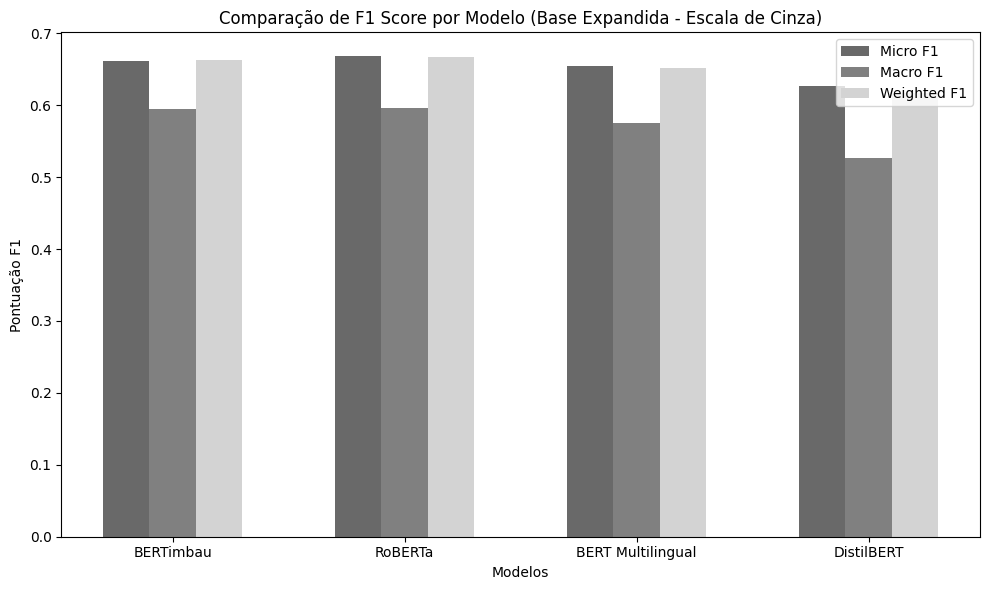

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Novos resultados dos modelos com base expandida
modelos = ["BERTimbau", "RoBERTa", "BERT Multilingual", "DistilBERT"]
micro_f1 = [0.6612, 0.6680, 0.6541, 0.6266]
macro_f1 = [0.5952, 0.5962, 0.5759, 0.5265]
weighted_f1 = [0.6633, 0.6668, 0.6518, 0.6170]

# Criar DataFrame
df = pd.DataFrame({
    "Modelo": modelos,
    "Micro F1": micro_f1,
    "Macro F1": macro_f1,
    "Weighted F1": weighted_f1
})

# Gráfico de barras em escala de cinza
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(modelos))

ax.bar(index, df["Micro F1"], bar_width, label="Micro F1", color="dimgray")
ax.bar(index + bar_width, df["Macro F1"], bar_width, label="Macro F1", color="gray")
ax.bar(index + 2 * bar_width, df["Weighted F1"], bar_width, label="Weighted F1", color="lightgray")

ax.set_xlabel("Modelos")
ax.set_ylabel("Pontuação F1")
ax.set_title("Comparação de F1 Score por Modelo (Base Expandida - Escala de Cinza)")
ax.set_xticks(index + bar_width)
ax.set_xticklabels(modelos)
ax.legend()
plt.tight_layout()
plt.show()


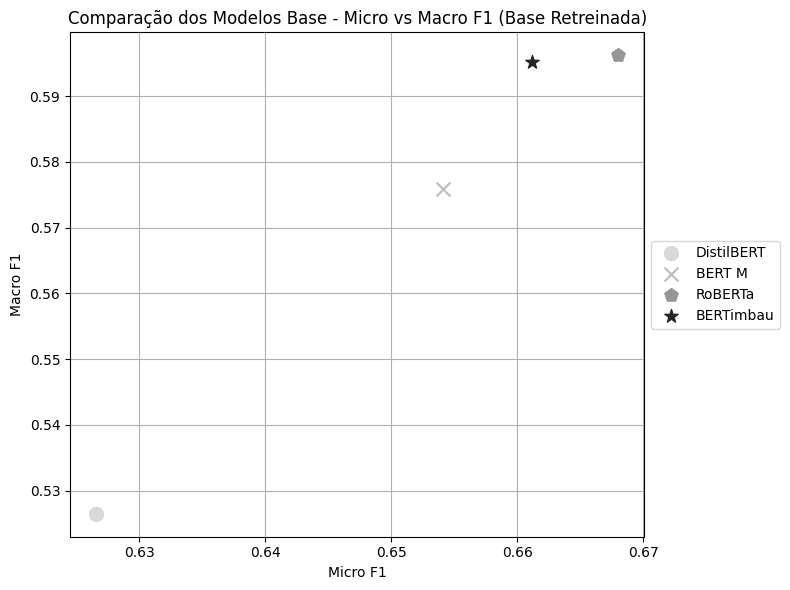

In [ ]:
import matplotlib.pyplot as plt

# Dados atualizados com os novos resultados da base retreinada
models = [
    "DistilBERT",
    "BERT M",
    "RoBERTa",
    "BERTimbau"
]
micro_f1 = [0.6266, 0.6541, 0.6680, 0.6612]
macro_f1 = [0.5265, 0.5759, 0.5962, 0.5952]

# Estilos (tons de cinza e marcadores diferentes)
colors = ["#d9d9d9", "#bdbdbd", "#969696", "#252525"]
markers = ['o', 'x', 'p', '*']

# Plot
plt.figure(figsize=(8, 6))
for i in range(len(models)):
    plt.scatter(micro_f1[i], macro_f1[i], color=colors[i], marker=markers[i], s=100, label=models[i])

plt.xlabel("Micro F1")
plt.ylabel("Macro F1")
plt.title("Comparação dos Modelos Base - Micro vs Macro F1 (Base Retreinada)")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()



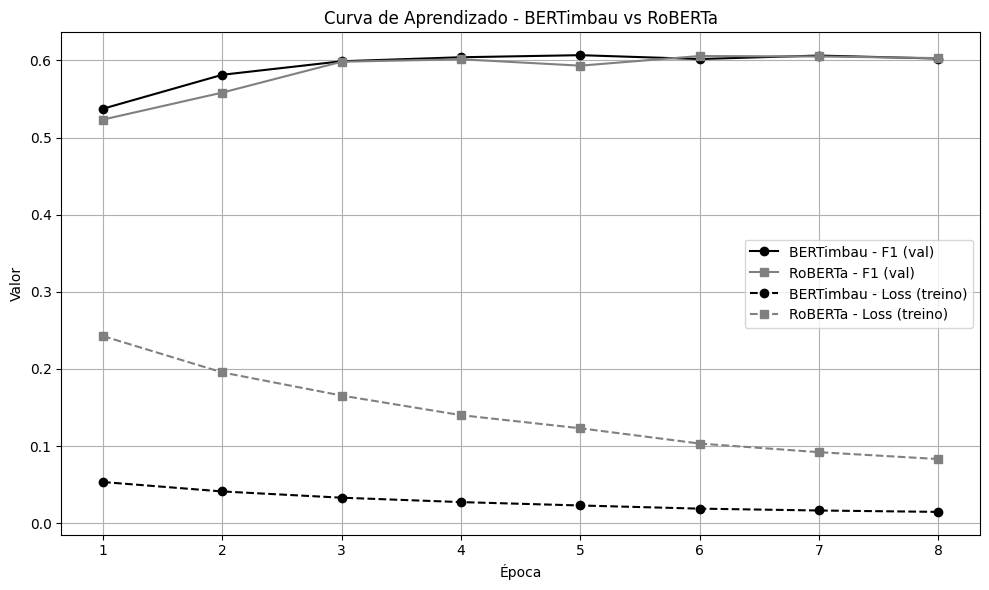

In [ ]:
import matplotlib.pyplot as plt

# Dados extraídos dos logs fornecidos anteriormente
epochs = list(range(1, 9))

# BERTimbau
bertimbau_f1 = [0.5374, 0.5814, 0.5989, 0.6041, 0.6068, 0.6018, 0.6063, 0.6024]
bertimbau_loss = [0.0534, 0.0412, 0.0331, 0.0274, 0.0230, 0.0189, 0.0165, 0.0147]

# RoBERTa
roberta_f1 = [0.5233, 0.5583, 0.5983, 0.6015, 0.5932, 0.6057, 0.6051, 0.6030]
roberta_loss = [0.2426, 0.1955, 0.1655, 0.1401, 0.1231, 0.1033, 0.0921, 0.0832]

# Plotando as curvas
plt.figure(figsize=(10, 6))

# F1-scores
plt.plot(epochs, bertimbau_f1, label="BERTimbau - F1 (val)", color="black", linestyle="-", marker="o")
plt.plot(epochs, roberta_f1, label="RoBERTa - F1 (val)", color="gray", linestyle="-", marker="s")

# Loss
plt.plot(epochs, bertimbau_loss, label="BERTimbau - Loss (treino)", color="black", linestyle="--", marker="o")
plt.plot(epochs, roberta_loss, label="RoBERTa - Loss (treino)", color="gray", linestyle="--", marker="s")

plt.xlabel("Época")
plt.ylabel("Valor")
plt.title("Curva de Aprendizado - BERTimbau vs RoBERTa")
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()



## EXPANDINDO EPOCHS

In [ ]:
# === 2. Definir modelo e tokenizer
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# === 3. Criar label2id e id2label com base nos spans
def get_label_set(examples):
    return sorted(set(span["label"] for spans in examples["spans"] for span in spans))

entity_labels = get_label_set(df)

prefixes = ["B-", "I-", "L-", "U-"]
label_list = ["O"] + [f"{p}{ent}" for ent in entity_labels for p in prefixes] + ["PAD"]

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# === 4. Função de tokenização com alinhamento BILOU
def bilou_encode(example):
    tokens = tokenizer(
        example["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_offsets_mapping=True
    )
    word_labels = ["O"] * len(tokens["input_ids"])
    offset_mapping = tokens["offset_mapping"]

    for span in example["spans"]:
        start, end, label = span["start"], span["end"], span["label"]
        matched = []

        for i, (s, e) in enumerate(offset_mapping):
            if s >= end or e <= start:
                continue
            matched.append(i)

        if len(matched) == 1:
            word_labels[matched[0]] = "U-" + label
        elif len(matched) >= 2:
            word_labels[matched[0]] = "B-" + label
            for i in matched[1:-1]:
                word_labels[i] = "I-" + label
            word_labels[matched[-1]] = "L-" + label

    tokens["labels"] = [label2id.get(tag, label2id["O"]) for tag in word_labels]
    return tokens

# === 5. Tokenizar e dividir o dataset
tokenized_dataset = dataset.map(bilou_encode, batched=False)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# === 6. Métricas com seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for pred, label in zip(predictions, labels):
        temp_preds, temp_labels = [], []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                temp_preds.append(id2label[p_i])
                temp_labels.append(id2label[l_i])
        true_predictions.append(temp_preds)
        true_labels.append(temp_labels)

    return {
        "precision": precision_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "recall": recall_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "f1": f1_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
    }

# === 7. Preparar modelo, argumentos e Trainer
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

use_cuda = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="./bertimbau2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    run_name="distilbert_bilou_ep8",
    save_total_limit=2
)




data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# === 8. Treinar modelo
trainer.train()

# === 9. Avaliação final
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions, axis=2)

true_preds = []
true_labels = []

for pred_seq, label_seq in zip(preds, labels):
    temp_preds, temp_labels = [], []
    for p_i, l_i in zip(pred_seq, label_seq):
        if l_i != -100:
            temp_preds.append(id2label[p_i])
            temp_labels.append(id2label[l_i])
    true_preds.append(temp_preds)
    true_labels.append(temp_labels)

print("📊 Relatório Final:")
print(classification_report(true_labels, true_preds, digits=4, scheme=BILOU, mode="strict"))

# === 10. Salvar modelo
model.save_pretrained("bertimbau2")
tokenizer.save_pretrained("bertimbau2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/15270 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-8dc50851e309>:110: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.042300,0.039415,0.760063,0.477893,0.586820
2,0.033600,0.038723,0.662751,0.633383,0.647734
3,0.028000,0.037066,0.705163,0.607878,0.652917
4,0.023000,0.037839,0.702885,0.614082,0.655490
5,0.020200,0.042902,0.657723,0.663811,0.660753
6,0.016000,0.047694,0.635293,0.690596,0.661791
7,0.014100,0.048337,0.659003,0.668932,0.663930
8,0.012600,0.051028,0.651090,0.676416,0.663511


📊 Relatório Final:
                 precision    recall  f1-score   support

  ATITUDE_VALOR     0.7714    0.8049    0.7878      2117
   CONHECIMENTO     0.7521    0.6932    0.7214      2236
     HABILIDADE     0.7130    0.7053    0.7092      3336
U-ATITUDE_VALOR     0.4327    0.5936    0.5006       374
 U-CONHECIMENTO     0.4049    0.3531    0.3772       422
   U-HABILIDADE     0.4389    0.4880    0.4621      1670

      micro avg     0.6590    0.6689    0.6639     10155
      macro avg     0.5855    0.6064    0.5931     10155
   weighted avg     0.6656    0.6689    0.6662     10155



('bertimbau2/tokenizer_config.json',
 'bertimbau2/special_tokens_map.json',
 'bertimbau2/vocab.txt',
 'bertimbau2/added_tokens.json',
 'bertimbau2/tokenizer.json')

In [ ]:
# === 2. Definir modelo e tokenizer
model_name = "thegoodfellas/tgf-xlm-roberta-base-pt-br"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# === 3. Criar label2id e id2label com base nos spans
def get_label_set(examples):
    return sorted(set(span["label"] for spans in examples["spans"] for span in spans))

entity_labels = get_label_set(df)

prefixes = ["B-", "I-", "L-", "U-"]
label_list = ["O"] + [f"{p}{ent}" for ent in entity_labels for p in prefixes] + ["PAD"]

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# === 4. Função de tokenização com alinhamento BILOU
def bilou_encode(example):
    tokens = tokenizer(example["text"], truncation=True, return_offsets_mapping=True)
    word_labels = ["O"] * len(tokens["input_ids"])
    offset_mapping = tokens["offset_mapping"]

    for span in example["spans"]:
        start, end, label = span["start"], span["end"], span["label"]
        matched = []

        for i, (s, e) in enumerate(offset_mapping):
            if s >= end or e <= start:
                continue
            matched.append(i)

        if len(matched) == 1:
            word_labels[matched[0]] = "U-" + label
        elif len(matched) >= 2:
            word_labels[matched[0]] = "B-" + label
            for i in matched[1:-1]:
                word_labels[i] = "I-" + label
            word_labels[matched[-1]] = "L-" + label

    tokens["labels"] = [label2id.get(tag, label2id["O"]) for tag in word_labels]
    return tokens

# === 5. Tokenizar e dividir o dataset
tokenized_dataset = dataset.map(bilou_encode, batched=False)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# === 6. Métricas com seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for pred, label in zip(predictions, labels):
        temp_preds, temp_labels = [], []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                temp_preds.append(id2label[p_i])
                temp_labels.append(id2label[l_i])
        true_predictions.append(temp_preds)
        true_labels.append(temp_labels)

    return {
        "precision": precision_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "recall": recall_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "f1": f1_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
    }

# === 7. Preparar modelo, argumentos e Trainer
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

use_cuda = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="./roberta2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    run_name="distilbert_bilou_ep8",
    save_total_limit=2
)




data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# === 8. Treinar modelo
trainer.train()

# === 9. Avaliação final
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions, axis=2)

true_preds = []
true_labels = []

for pred_seq, label_seq in zip(preds, labels):
    temp_preds, temp_labels = [], []
    for p_i, l_i in zip(pred_seq, label_seq):
        if l_i != -100:
            temp_preds.append(id2label[p_i])
            temp_labels.append(id2label[l_i])
    true_preds.append(temp_preds)
    true_labels.append(temp_labels)

print("📊 Relatório Final:")
print(classification_report(true_labels, true_preds, digits=4, scheme=BILOU, mode="strict"))

# === 10. Salvar modelo
model.save_pretrained("roberta_pt_br2")
tokenizer.save_pretrained("roberta_pt_br2")

tokenizer_config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/15270 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at thegoodfellas/tgf-xlm-roberta-base-pt-br and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-9855536d7b07>:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.221200,0.207375,0.769846,0.464198,0.579171
2,0.182900,0.203570,0.647490,0.651827,0.649652
3,0.156900,0.190011,0.696460,0.623954,0.658216
4,0.135100,0.195206,0.711170,0.610164,0.656807
5,0.120500,0.216888,0.655857,0.677238,0.666376
6,0.099800,0.226722,0.663561,0.666503,0.665029
7,0.087700,0.244300,0.668104,0.656062,0.662029
8,0.076700,0.257313,0.664876,0.658328,0.661586


📊 Relatório Final:
                 precision    recall  f1-score   support

  ATITUDE_VALOR     0.7651    0.8027    0.7835      2114
   CONHECIMENTO     0.7275    0.7187    0.7231      2236
     HABILIDADE     0.7053    0.7135    0.7094      3337
U-ATITUDE_VALOR     0.4509    0.5775    0.5064       374
 U-CONHECIMENTO     0.4413    0.3744    0.4051       422
   U-HABILIDADE     0.4431    0.4892    0.4650      1670

      micro avg     0.6559    0.6772    0.6664     10153
      macro avg     0.5889    0.6127    0.5987     10153
   weighted avg     0.6592    0.6772    0.6675     10153



('roberta_pt_br2/tokenizer_config.json',
 'roberta_pt_br2/special_tokens_map.json',
 'roberta_pt_br2/tokenizer.json')

## LARGES

In [ ]:
# === 2. Definir modelo e tokenizer
model_name = "neuralmind/bert-large-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# === 3. Criar label2id e id2label com base nos spans
def get_label_set(examples):
    return sorted(set(span["label"] for spans in examples["spans"] for span in spans))

entity_labels = get_label_set(df)

prefixes = ["B-", "I-", "L-", "U-"]
label_list = ["O"] + [f"{p}{ent}" for ent in entity_labels for p in prefixes] + ["PAD"]

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# === 4. Função de tokenização com alinhamento BILOU
def bilou_encode(example):
    tokens = tokenizer(
        example["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_offsets_mapping=True
    )
    word_labels = ["O"] * len(tokens["input_ids"])
    offset_mapping = tokens["offset_mapping"]

    for span in example["spans"]:
        start, end, label = span["start"], span["end"], span["label"]
        matched = []

        for i, (s, e) in enumerate(offset_mapping):
            if s >= end or e <= start:
                continue
            matched.append(i)

        if len(matched) == 1:
            word_labels[matched[0]] = "U-" + label
        elif len(matched) >= 2:
            word_labels[matched[0]] = "B-" + label
            for i in matched[1:-1]:
                word_labels[i] = "I-" + label
            word_labels[matched[-1]] = "L-" + label

    tokens["labels"] = [label2id.get(tag, label2id["O"]) for tag in word_labels]
    return tokens

# === 5. Tokenizar e dividir o dataset
tokenized_dataset = dataset.map(bilou_encode, batched=False)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# === 6. Métricas com seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for pred, label in zip(predictions, labels):
        temp_preds, temp_labels = [], []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                temp_preds.append(id2label[p_i])
                temp_labels.append(id2label[l_i])
        true_predictions.append(temp_preds)
        true_labels.append(temp_labels)

    return {
        "precision": precision_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "recall": recall_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "f1": f1_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
    }

# === 7. Preparar modelo, argumentos e Trainer
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

use_cuda = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="./bertimbau_large",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    run_name="distilbert_bilou_ep8",
    save_total_limit=2
)




data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# === 8. Treinar modelo
trainer.train()

# === 9. Avaliação final
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions, axis=2)

true_preds = []
true_labels = []

for pred_seq, label_seq in zip(preds, labels):
    temp_preds, temp_labels = [], []
    for p_i, l_i in zip(pred_seq, label_seq):
        if l_i != -100:
            temp_preds.append(id2label[p_i])
            temp_labels.append(id2label[l_i])
    true_preds.append(temp_preds)
    true_labels.append(temp_labels)

print("📊 Relatório Final:")
print(classification_report(true_labels, true_preds, digits=4, scheme=BILOU, mode="strict"))

# === 10. Salvar modelo
model.save_pretrained("bertimbau_large")
tokenizer.save_pretrained("bertimbau_large")

tokenizer_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/15270 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-large-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-d4f216e9921f>:111: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.039100,0.038163,0.774834,0.483900,0.595745
2,0.031200,0.036625,0.671324,0.652880,0.661974
3,0.024700,0.035837,0.706898,0.636731,0.669982
4,0.018600,0.039450,0.712101,0.632792,0.670108
5,0.015000,0.044076,0.686498,0.657903,0.671896
6,0.011100,0.047947,0.687991,0.664008,0.675787
7,0.008800,0.052699,0.693634,0.653471,0.672954
8,0.006900,0.056327,0.691236,0.654751,0.672499


📊 Relatório Final:
                 precision    recall  f1-score   support

  ATITUDE_VALOR     0.8008    0.7898    0.7952      2117
   CONHECIMENTO     0.7797    0.7013    0.7384      2236
     HABILIDADE     0.7244    0.7263    0.7253      3336
U-ATITUDE_VALOR     0.4385    0.5053    0.4696       374
 U-CONHECIMENTO     0.4829    0.3673    0.4172       422
   U-HABILIDADE     0.4586    0.4407    0.4495      1670

      micro avg     0.6880    0.6640    0.6758     10155
      macro avg     0.6141    0.5885    0.5992     10155
   weighted avg     0.6882    0.6640    0.6752     10155



('bertimbau_large/tokenizer_config.json',
 'bertimbau_large/special_tokens_map.json',
 'bertimbau_large/vocab.txt',
 'bertimbau_large/added_tokens.json',
 'bertimbau_large/tokenizer.json')

In [ ]:
# === 2. Definir modelo e tokenizer
model_name = "FacebookAI/xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# === 3. Criar label2id e id2label com base nos spans
def get_label_set(examples):
    return sorted(set(span["label"] for spans in examples["spans"] for span in spans))

entity_labels = get_label_set(df)

prefixes = ["B-", "I-", "L-", "U-"]
label_list = ["O"] + [f"{p}{ent}" for ent in entity_labels for p in prefixes] + ["PAD"]

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# === 4. Função de tokenização com alinhamento BILOU
def bilou_encode(example):
    tokens = tokenizer(example["text"], truncation=True, return_offsets_mapping=True)
    word_labels = ["O"] * len(tokens["input_ids"])
    offset_mapping = tokens["offset_mapping"]

    for span in example["spans"]:
        start, end, label = span["start"], span["end"], span["label"]
        matched = []

        for i, (s, e) in enumerate(offset_mapping):
            if s >= end or e <= start:
                continue
            matched.append(i)

        if len(matched) == 1:
            word_labels[matched[0]] = "U-" + label
        elif len(matched) >= 2:
            word_labels[matched[0]] = "B-" + label
            for i in matched[1:-1]:
                word_labels[i] = "I-" + label
            word_labels[matched[-1]] = "L-" + label

    tokens["labels"] = [label2id.get(tag, label2id["O"]) for tag in word_labels]
    return tokens

# === 5. Tokenizar e dividir o dataset
tokenized_dataset = dataset.map(bilou_encode, batched=False)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# === 6. Métricas com seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for pred, label in zip(predictions, labels):
        temp_preds, temp_labels = [], []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                temp_preds.append(id2label[p_i])
                temp_labels.append(id2label[l_i])
        true_predictions.append(temp_preds)
        true_labels.append(temp_labels)

    return {
        "precision": precision_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "recall": recall_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
        "f1": f1_score(true_labels, true_predictions, mode="strict", scheme=BILOU),
    }

# === 7. Preparar modelo, argumentos e Trainer
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

use_cuda = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir="./roberta_large",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    run_name="distilbert_bilou_ep8",
    save_total_limit=2
)




data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# === 8. Treinar modelo
trainer.train()

# === 9. Avaliação final
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions, axis=2)

true_preds = []
true_labels = []

for pred_seq, label_seq in zip(preds, labels):
    temp_preds, temp_labels = [], []
    for p_i, l_i in zip(pred_seq, label_seq):
        if l_i != -100:
            temp_preds.append(id2label[p_i])
            temp_labels.append(id2label[l_i])
    true_preds.append(temp_preds)
    true_labels.append(temp_labels)

print("📊 Relatório Final:")
print(classification_report(true_labels, true_preds, digits=4, scheme=BILOU, mode="strict"))

# === 10. Salvar modelo
model.save_pretrained("roberta_pt_br_large")
tokenizer.save_pretrained("roberta_pt_br_large")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/15270 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-8-63b6e2079707>:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.209000,0.205577,0.783235,0.471191,0.588402
2,0.172200,0.193670,0.641110,0.689353,0.664357
3,0.137800,0.192307,0.726928,0.623757,0.671402
4,0.112100,0.206786,0.741290,0.595194,0.660257
5,0.091800,0.227399,0.675423,0.683739,0.679556
6,0.070500,0.252625,0.688482,0.673496,0.680906
7,0.053200,0.294998,0.695467,0.660396,0.677478
8,0.040400,0.317541,0.690231,0.667389,0.678618


📊 Relatório Final:
                 precision    recall  f1-score   support

  ATITUDE_VALOR     0.7915    0.8027    0.7971      2114
   CONHECIMENTO     0.7775    0.7330    0.7546      2236
     HABILIDADE     0.7475    0.7141    0.7304      3337
U-ATITUDE_VALOR     0.4602    0.5107    0.4842       374
 U-CONHECIMENTO     0.4609    0.4194    0.4392       422
   U-HABILIDADE     0.4436    0.4497    0.4466      1670

      micro avg     0.6885    0.6735    0.6809     10153
      macro avg     0.6135    0.6049    0.6087     10153
   weighted avg     0.6908    0.6735    0.6818     10153



('roberta_pt_br_large/tokenizer_config.json',
 'roberta_pt_br_large/special_tokens_map.json',
 'roberta_pt_br_large/sentencepiece.bpe.model',
 'roberta_pt_br_large/added_tokens.json',
 'roberta_pt_br_large/tokenizer.json')

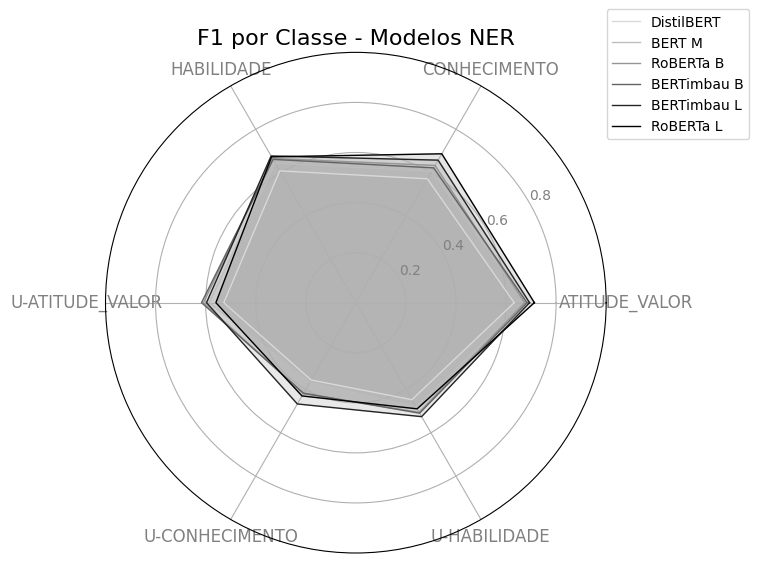

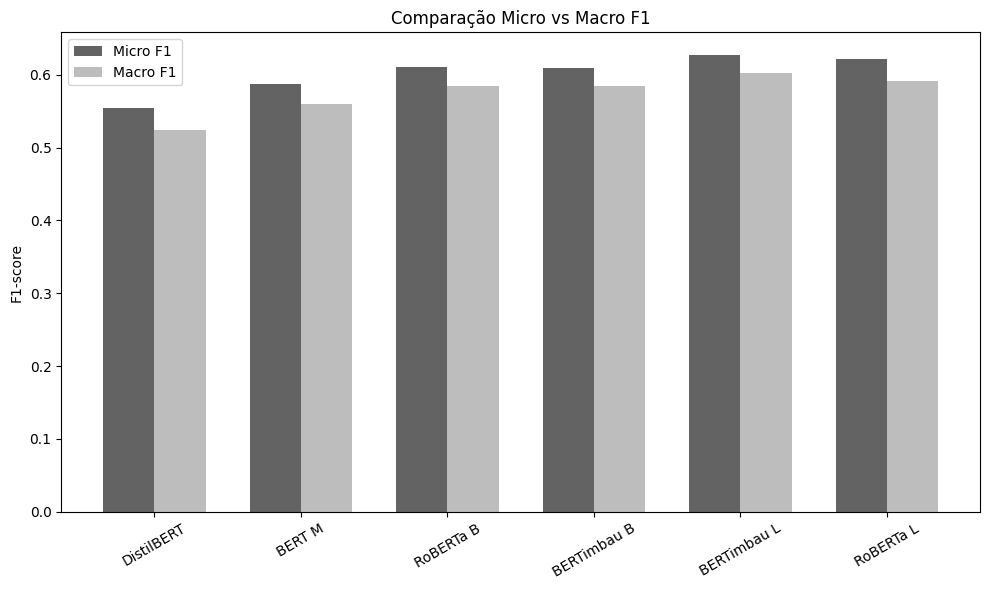

In [ ]:
# Reimportar bibliotecas após reset do estado
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi

# === Dados por classe (F1-score final dos relatórios)
labels = [
    "ATITUDE_VALOR", "CONHECIMENTO", "HABILIDADE",
    "U-ATITUDE_VALOR", "U-CONHECIMENTO", "U-HABILIDADE"
]

# Valores de F1 por modelo
f1_scores = {
    "DistilBERT": [0.6326, 0.5715, 0.6080, 0.5275, 0.3567, 0.4475],
    "BERT M": [0.6757, 0.6061, 0.6434, 0.5854, 0.3676, 0.4805],
    "RoBERTa B": [0.6743, 0.6331, 0.6654, 0.6087, 0.4199, 0.5058],
    "BERTimbau B": [0.6838, 0.6219, 0.6610, 0.6164, 0.4176, 0.5098],
    "BERTimbau L": [0.6939, 0.6575, 0.6768, 0.5965, 0.4672, 0.5257],
    "RoBERTa L": [0.7133, 0.6868, 0.6729, 0.5590, 0.4302, 0.4897],
}

# === Radar Chart ===
def plot_radar(f1_scores, labels):
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], labels, color='grey', size=12)
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    plt.ylim(0, 1)

    grayscale = ["#d9d9d9", "#bdbdbd", "#969696", "#636363", "#252525", "#000000"]

    for i, (model, values) in enumerate(f1_scores.items()):
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model, color=grayscale[i])
        ax.fill(angles, values, alpha=0.1, color=grayscale[i])

    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title("F1 por Classe - Modelos NER", size=16)
    plt.tight_layout()
    return fig

# === Gráfico de barras para micro/macro
def plot_micro_macro():
    models = list(f1_scores.keys())
    micro = [0.5547, 0.5871, 0.6105, 0.6086, 0.6269, 0.6217]
    macro = [0.5240, 0.5598, 0.5845, 0.5851, 0.6029, 0.5920]

    x = np.arange(len(models))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, micro, width, label='Micro F1', color='#636363')
    ax.bar(x + width/2, macro, width, label='Macro F1', color='#bdbdbd')
    ax.set_ylabel('F1-score')
    ax.set_title('Comparação Micro vs Macro F1')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=30)
    ax.legend()
    plt.tight_layout()
    return fig

# Gerar os gráficos
fig1 = plot_radar(f1_scores, labels)
fig2 = plot_micro_macro()
plt.show()


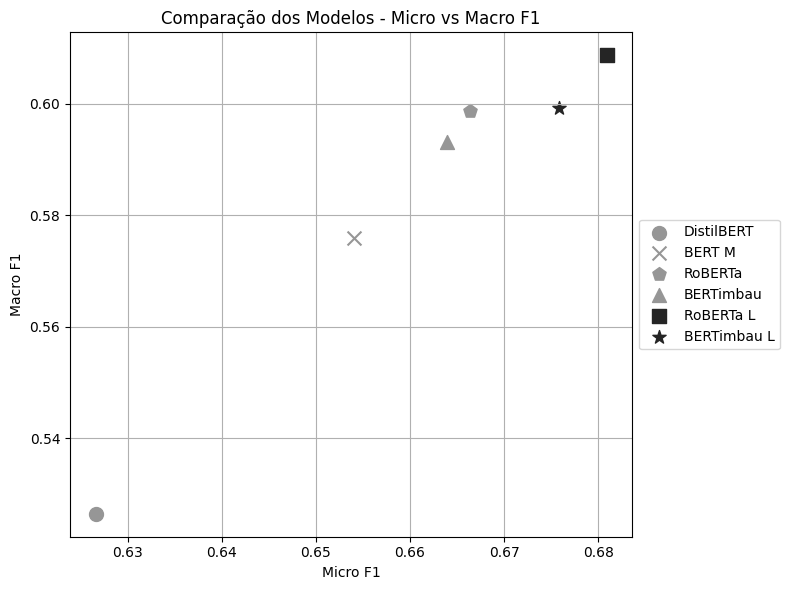

In [ ]:
import matplotlib.pyplot as plt

# === 1. Gráfico de Micro vs Macro F1 ===

# Dados atualizados
models = [
    "DistilBERT",
    "BERT M",
    "RoBERTa",
    "BERTimbau",
    "RoBERTa L",
    "BERTimbau L"
]

micro_f1 = [0.6266, 0.6541, 0.6664, 0.6639, 0.6809, 0.6758]
macro_f1 = [0.5265, 0.5759, 0.5987, 0.5931, 0.6087, 0.5992]

# Estilos (tons de cinza e marcadores diferentes)
colors = ["#969696", "#969696", "#969696", "#969696", "#252525", "#252525"]
markers = ['o', 'x', 'p', '^', 's', '*']

# Plot
plt.figure(figsize=(8, 6))
for i in range(len(models)):
    plt.scatter(micro_f1[i], macro_f1[i], color=colors[i], marker=markers[i], s=100, label=models[i])

plt.xlabel("Micro F1")
plt.ylabel("Macro F1")
plt.title("Comparação dos Modelos - Micro vs Macro F1")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

